# **Data and Configuration**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid", palette="muted")
%config InlineBackend.figure_format = 'retina'

df = pd.read_csv('insurance.csv')

# **Data processing and EDA**

In [3]:
print("Пропущенные значения:")
print(df.isnull().sum())
print("\nДубликаты:", df.duplicated().sum())

print("\nОсновная информация:")
print(df.info())

print("\nОсновные статистики:")
print(df.describe())

print("\nУникальные значения:")
print(df.nunique())

Пропущенные значения:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Дубликаты: 1

Основная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

Основные статистики:
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1

In [4]:
df = df.drop_duplicates()

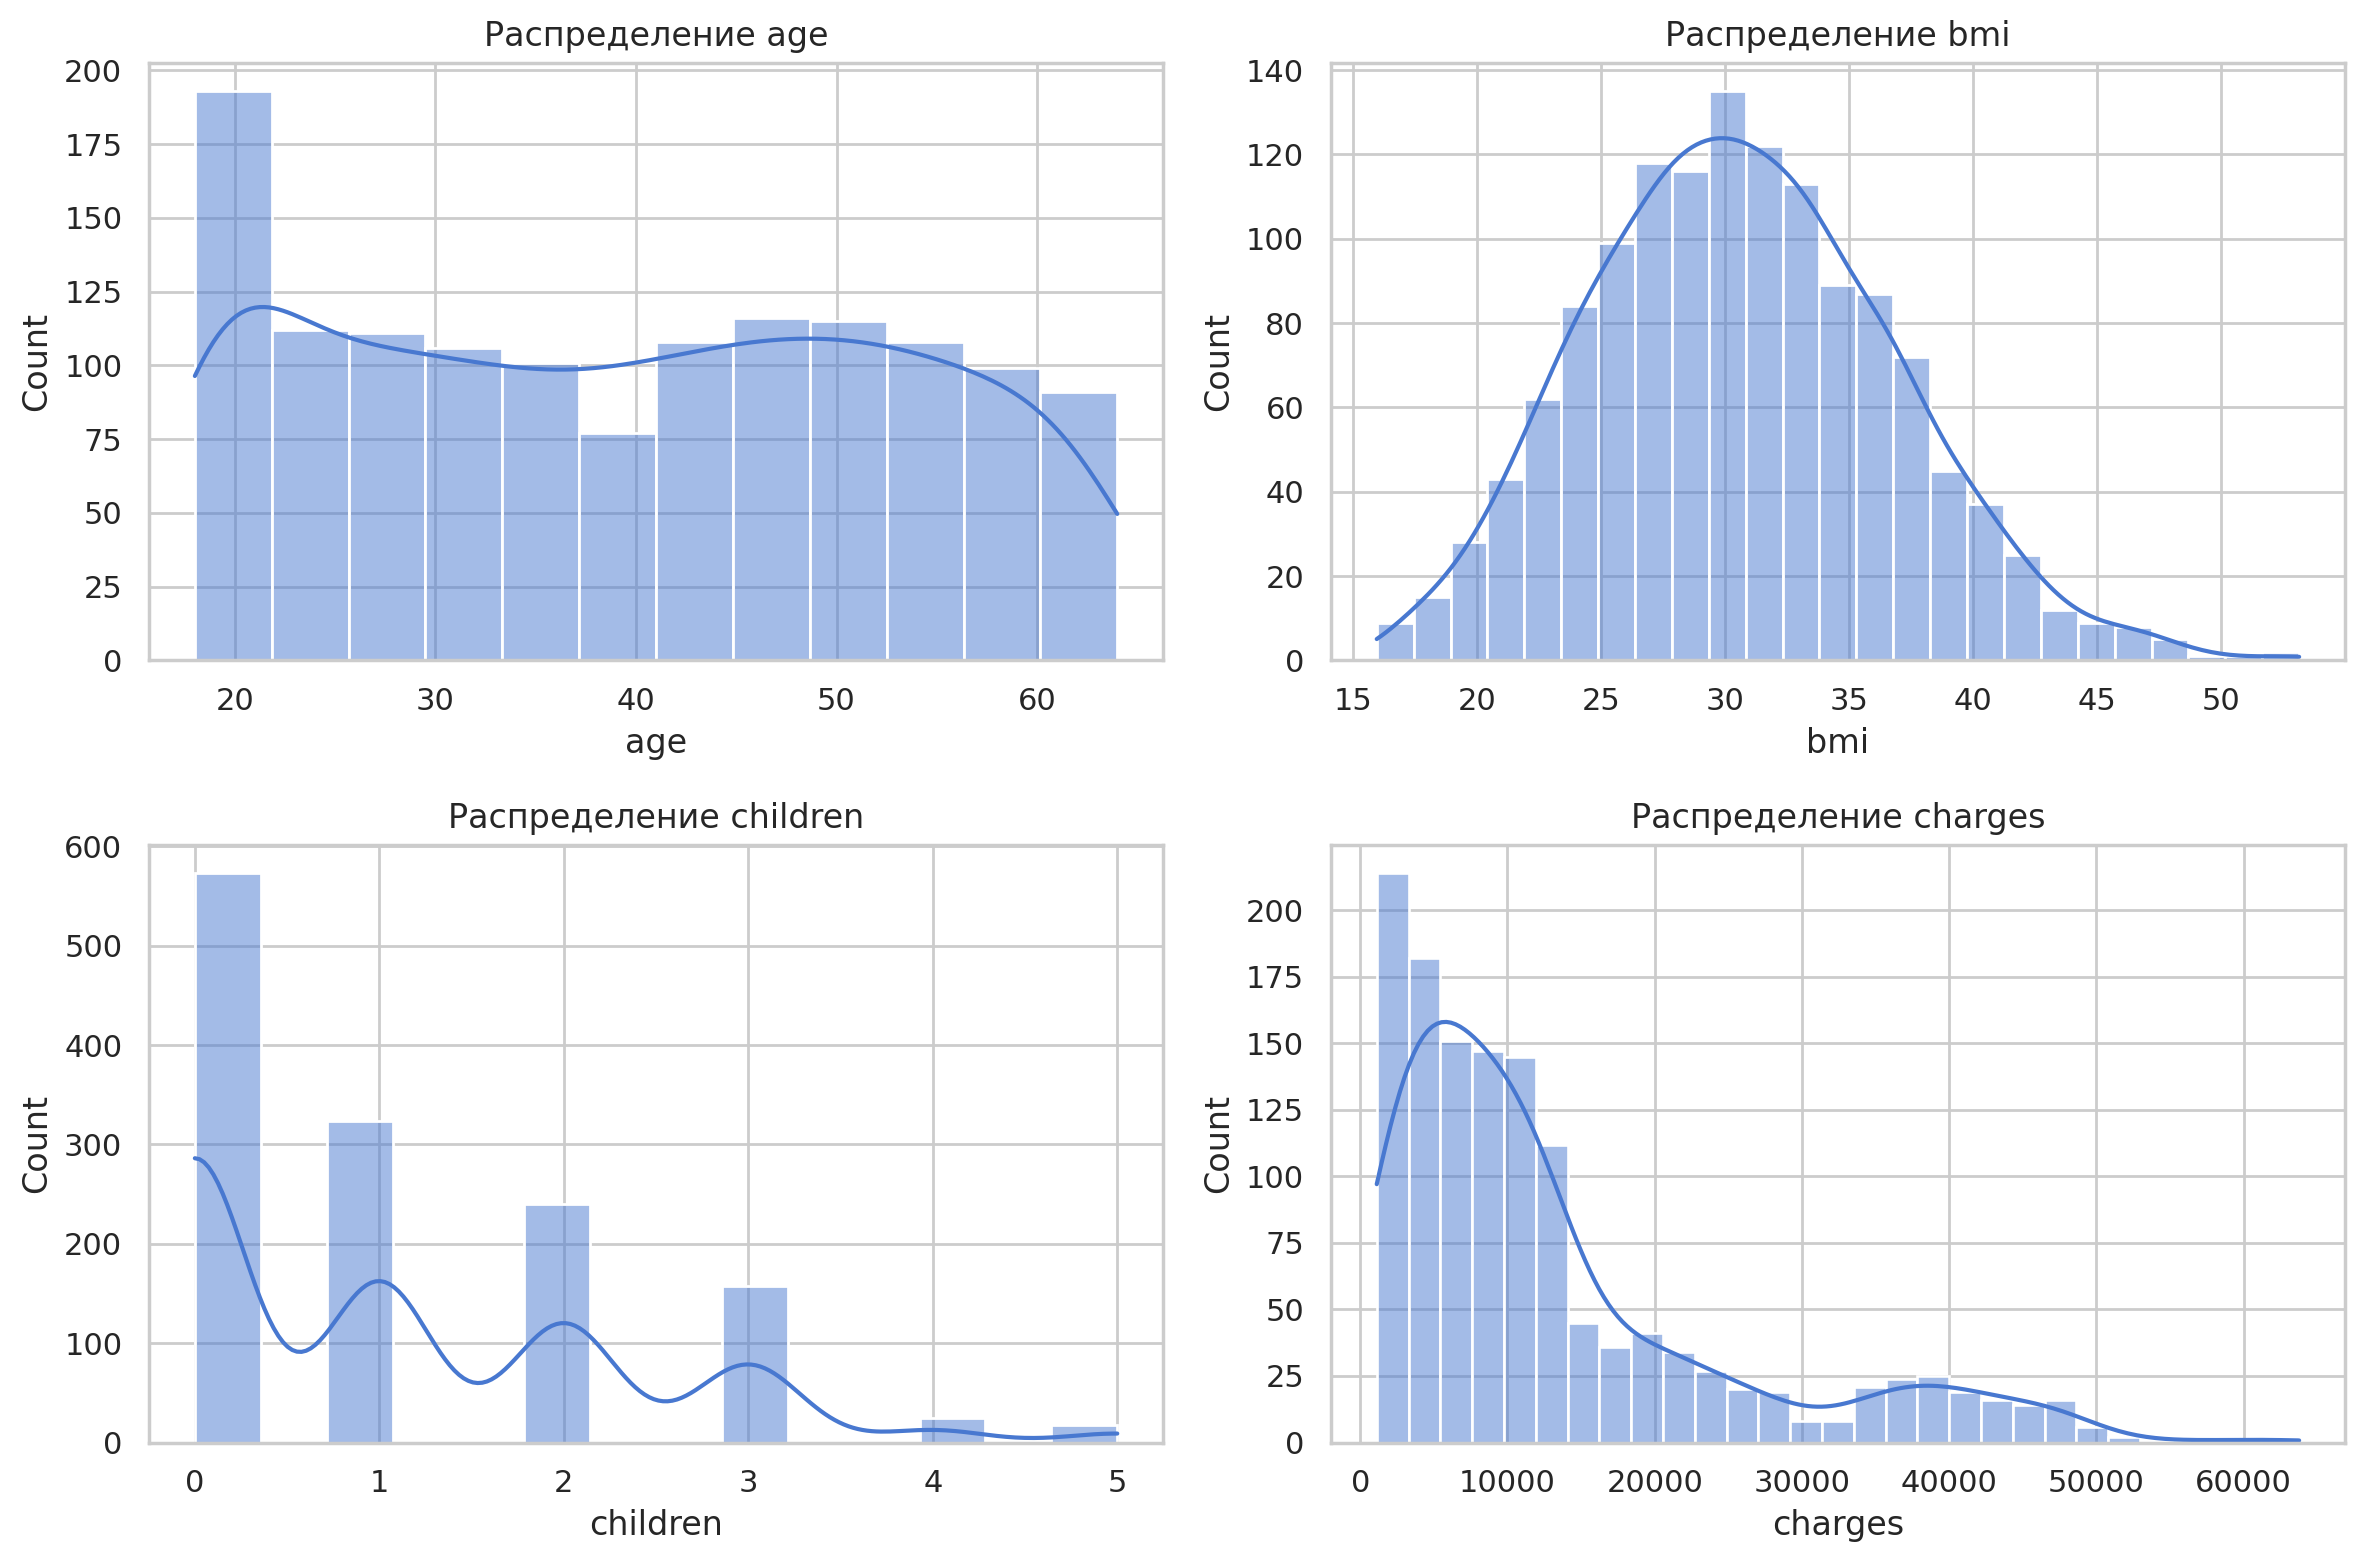

In [8]:
num_cols = ['age', 'bmi', 'children', 'charges']
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, col in zip(axes.flat, num_cols):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f'Распределение {col}')
plt.tight_layout()

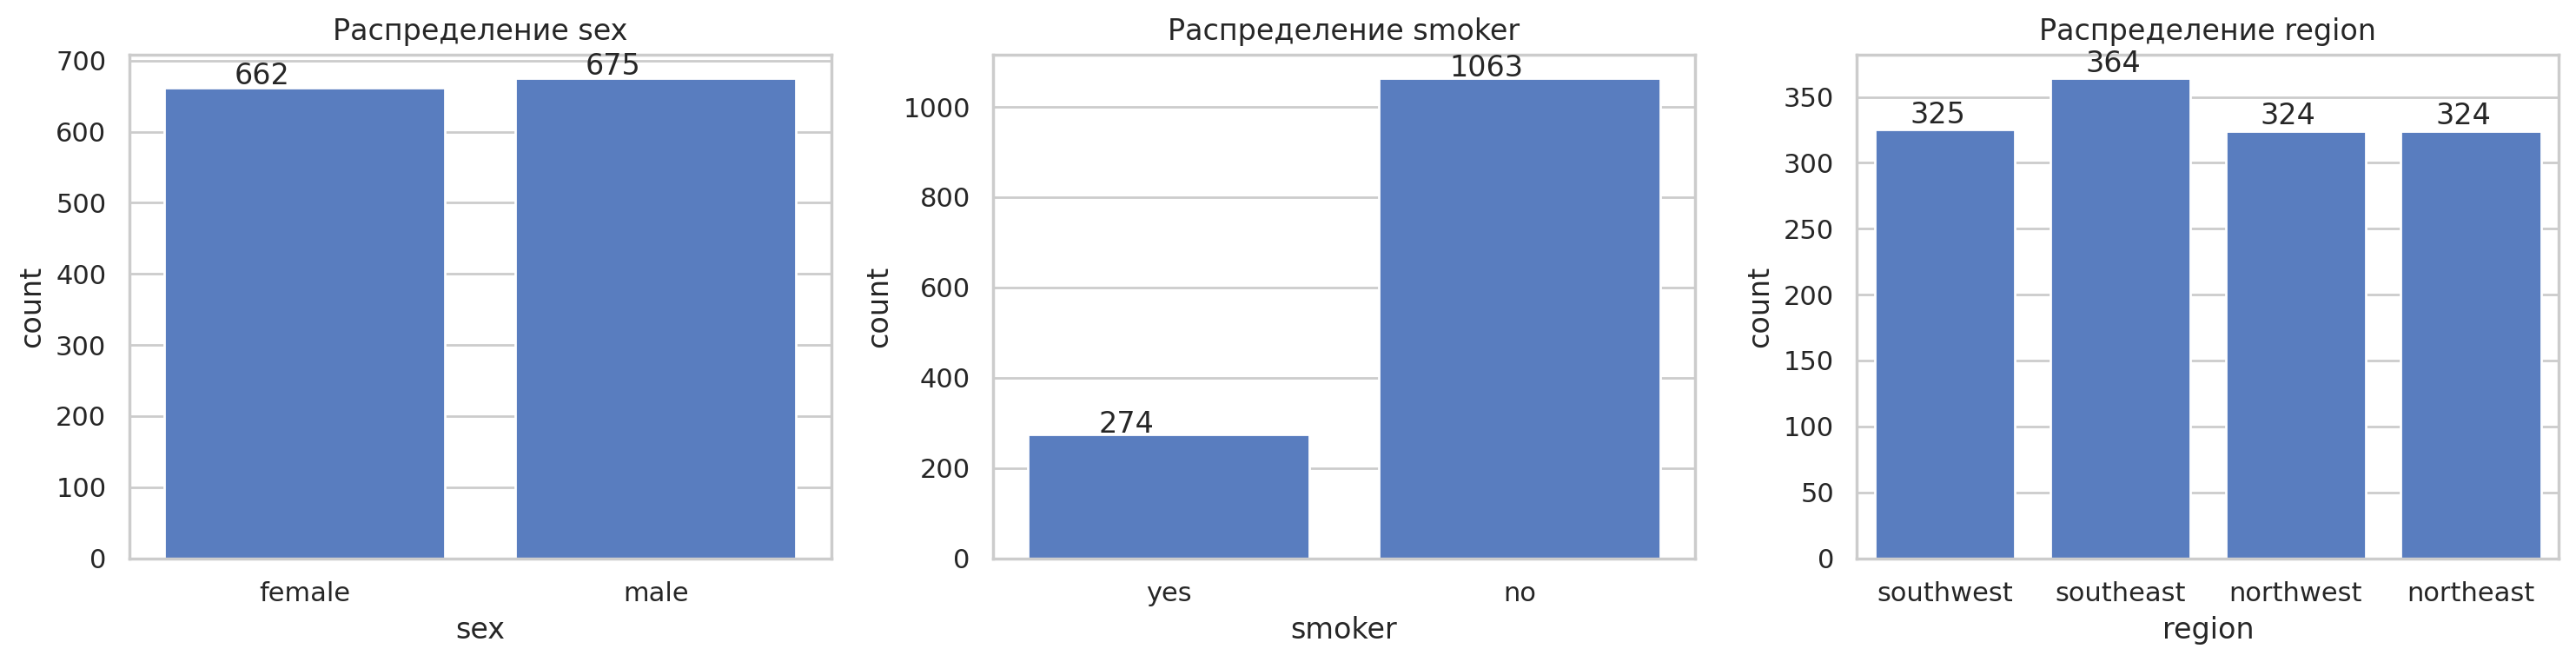

In [9]:
cat_cols = ['sex', 'smoker', 'region']
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, col in zip(axes, cat_cols):
    sns.countplot(x=col, data=df, ax=ax)
    ax.set_title(f'Распределение {col}')
    for p in ax.patches:
        ax.annotate(int(p.get_height()), (p.get_x()+0.2, p.get_height()+5))
plt.tight_layout()

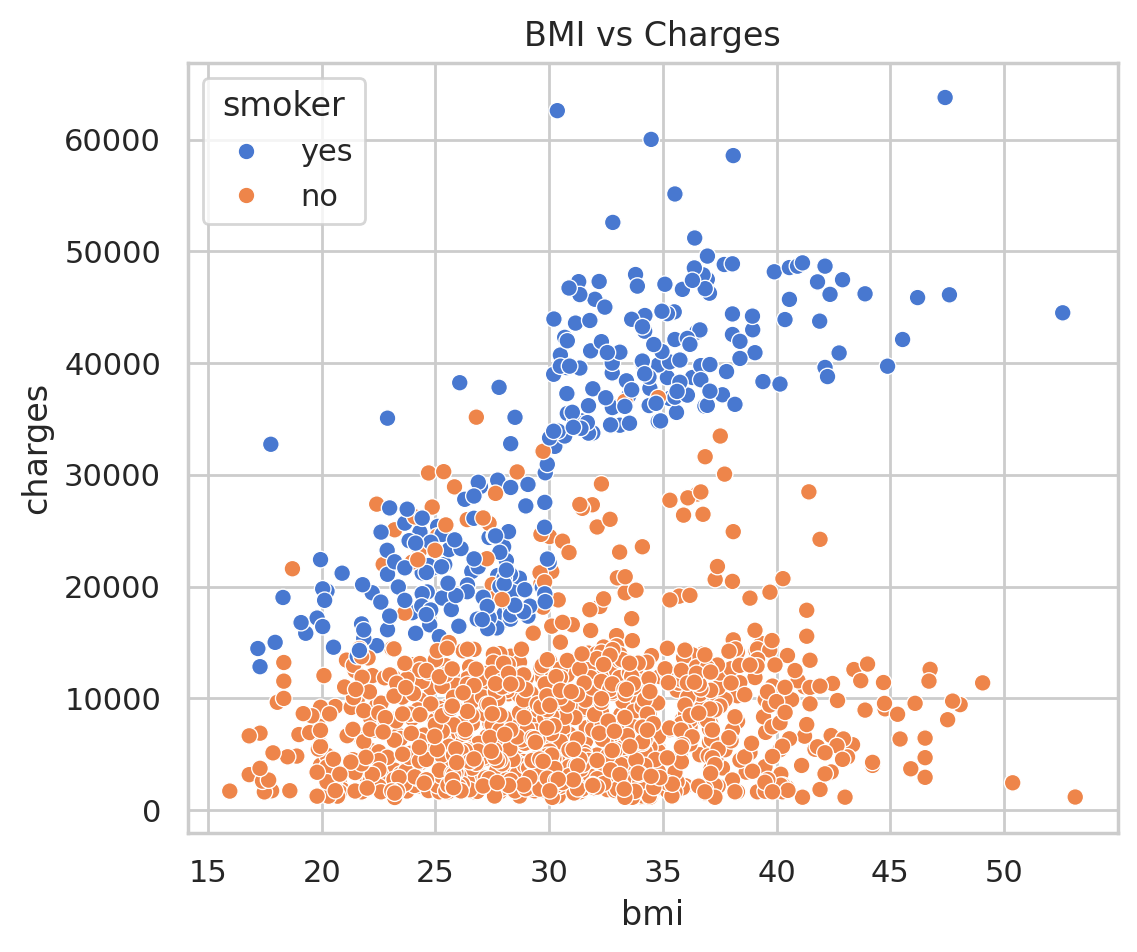

In [10]:
plt.figure(figsize=(6,5))
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df)
plt.title('BMI vs Charges')
plt.show()

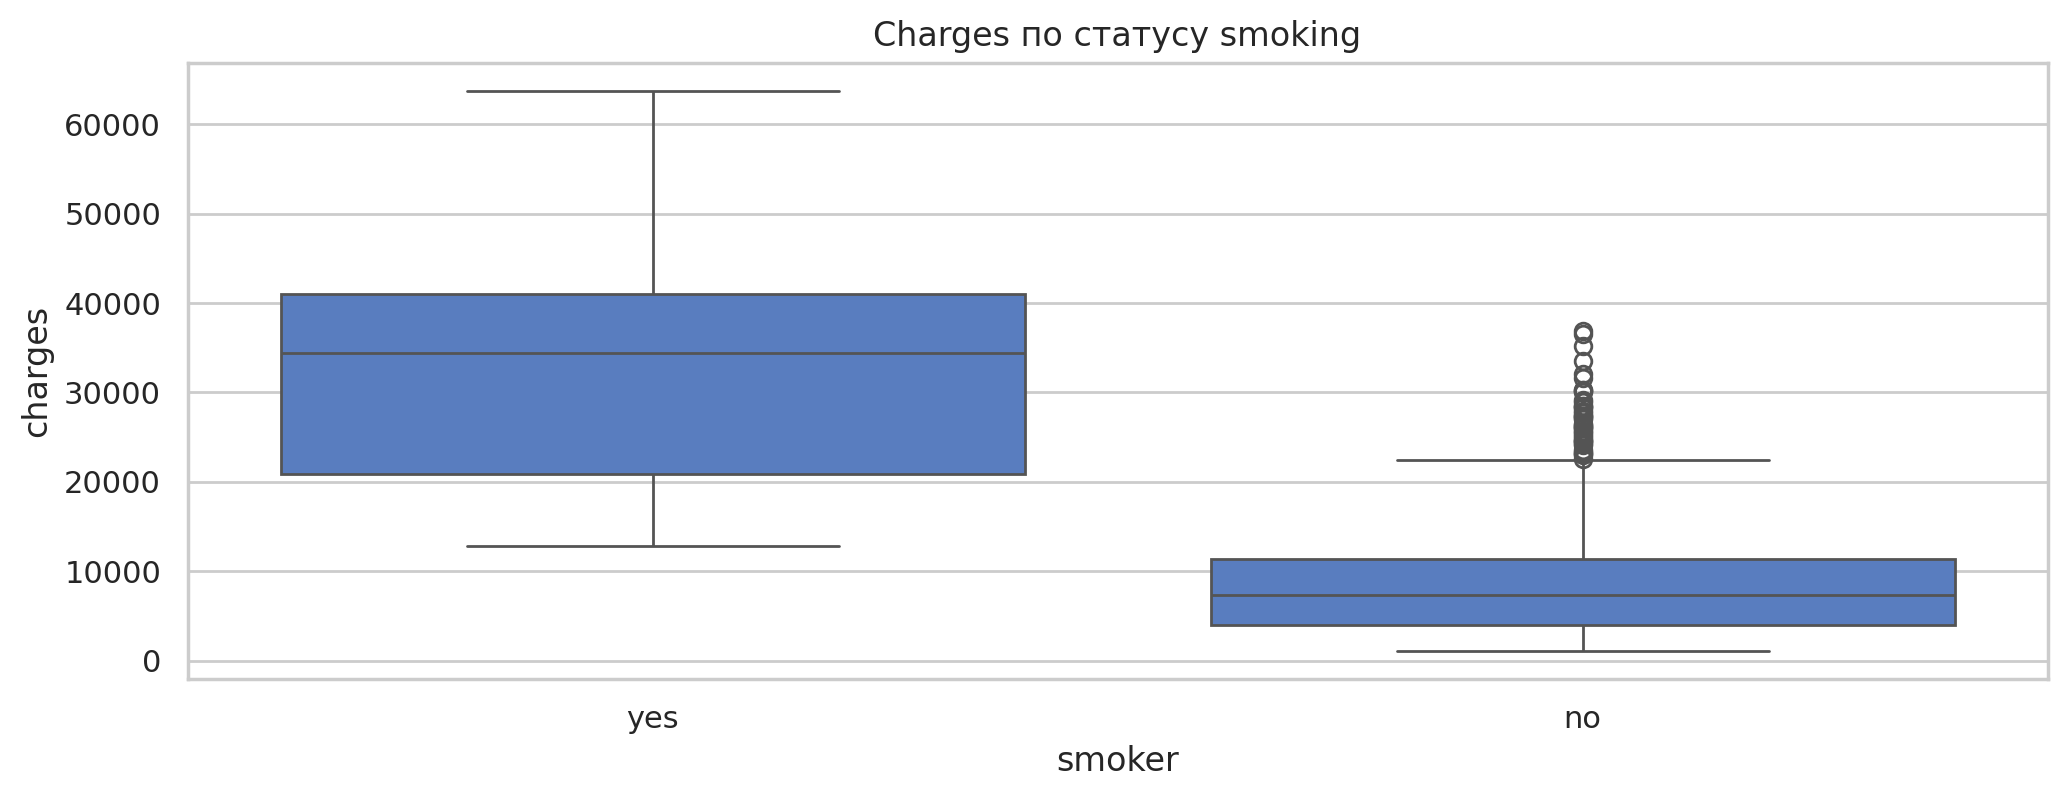

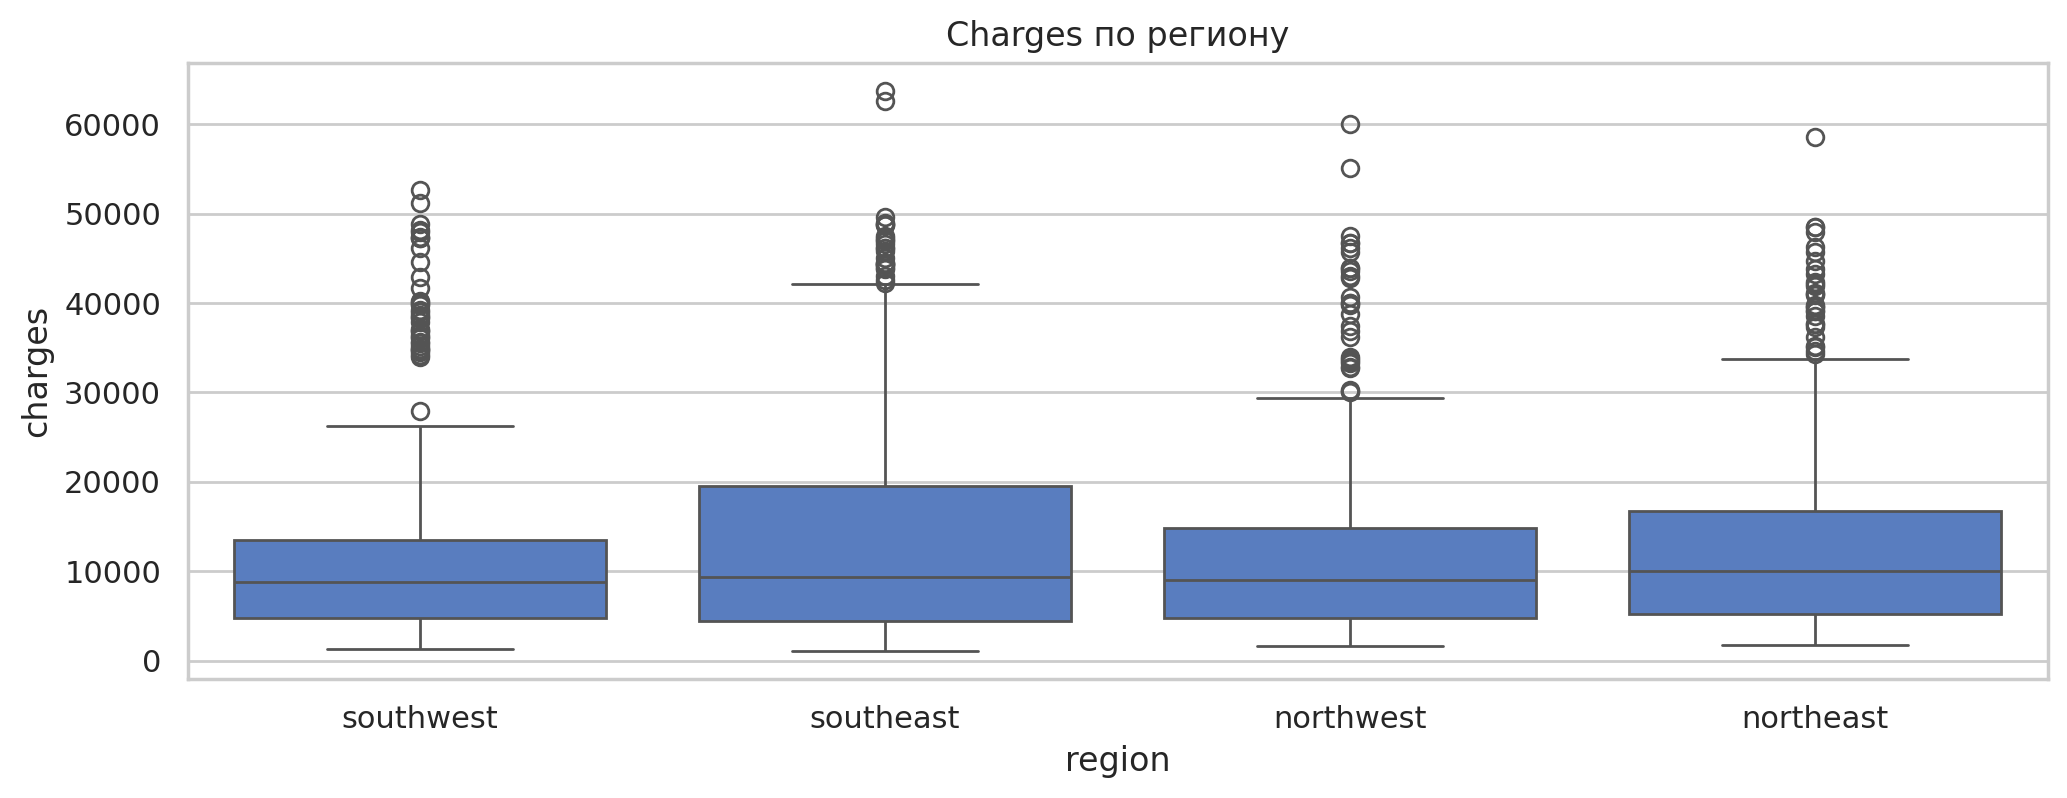

In [11]:
plt.figure(figsize=(12,4))
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Charges по статусу smoking')
plt.show()

plt.figure(figsize=(12,4))
sns.boxplot(x='region', y='charges', data=df)
plt.title('Charges по региону')
plt.show()

# **Feature Engineering**

In [119]:
df = df.copy()

df['bmi_age'] = df['bmi'] * df['age']
df['bmi_age_smoker'] = df['bmi_age'] * df['smoker'].map({'yes': 1, 'no': 0})
df['binary_smoker'] = df['smoker'].map({'yes': 1, 'no': 0})

def bmi_category(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif bmi < 25:
        return 'normal'
    elif bmi < 30:
        return 'overweight'
    else:
        return 'obese'

df['bmi_group'] = df['bmi'].apply(bmi_category)

def age_group(age):
    if age < 26:
        return 'Young'
    elif age < 40:
        return 'Adult'
    elif age < 60:
        return 'Middle aged'
    else:
        return 'Senior'

df['age_group'] = df['age'].apply(age_group)

print("Размер датафрейма:", df.shape)
display(df.head(5))

Размер датафрейма: (1337, 12)


,age,sex,bmi,children,smoker,region,charges,bmi_group,age_group,bmi_age_smoker,bmi_age,binary_smoker
0,19,female,27.900,0,yes,southwest,16884.92400,overweight,Young,530.1,530.100,1
1,18,male,33.770,1,no,southeast,1725.55230,obese,Young,0.0,607.860,0
2,28,male,33.000,3,no,southeast,4449.46200,obese,Adult,0.0,924.000,0
3,33,male,22.705,0,no,northwest,21984.47061,normal,Adult,0.0,749.265,0
4,32,male,28.880,0,no,northwest,3866.85520,overweight,Adult,0.0,924.160,0


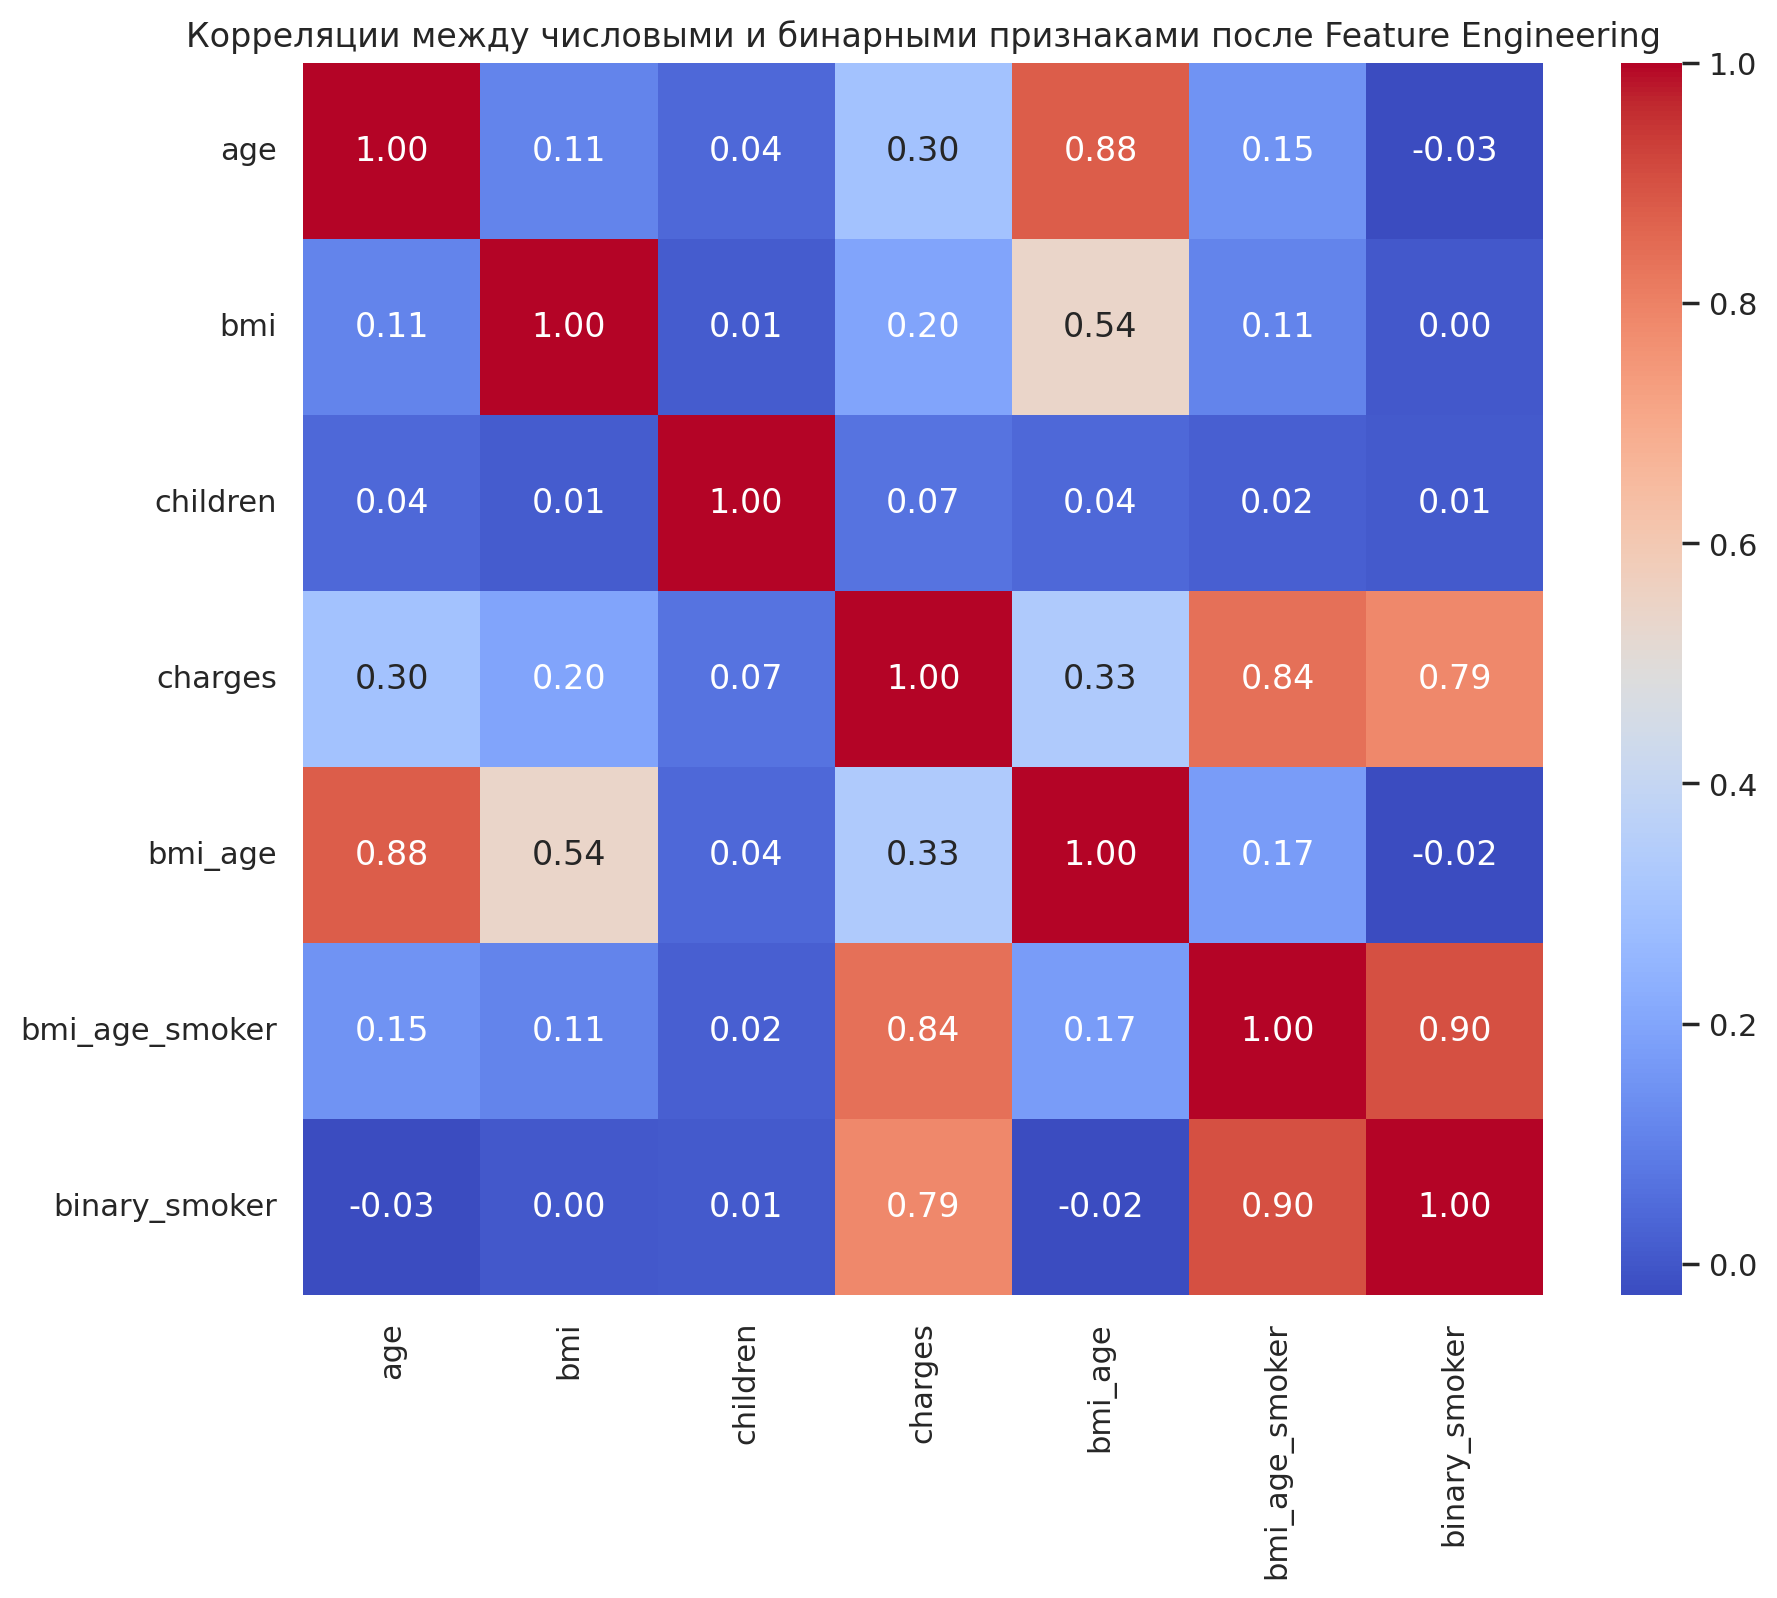

In [109]:
numeric_and_binary_cols_after_fe = [
    'age', 'bmi', 'children', 'charges',
    'bmi_age', 'bmi_age_smoker', 'binary_smoker'
]

cols_to_correlate = [col for col in numeric_and_binary_cols_after_fe if col in df.columns]


corr_after_fe = df[cols_to_correlate].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(corr_after_fe, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляции между числовыми и бинарными признаками после Feature Engineering')
plt.show()

# **Model Training and Testing**

5‑fold CV RMSE
LinearRegression : 5698.13 ± 189.71
RandomForest     : 4817.72 ± 400.53
GradientBoosting : 4706.19 ± 452.18
XGBoost          : 4982.12 ± 332.11

Hold‑out Metrics


,RMSE,MAE,R2
model,,,
LinearRegression,5556.096346,3958.167317,0.832004
RandomForest,4592.924072,2554.304345,0.885201
GradientBoosting,4428.252730,2606.511045,0.893286
XGBoost,4725.463601,2780.007166,0.878480



Лучшая модель: GradientBoosting с RMSE = 4428.25


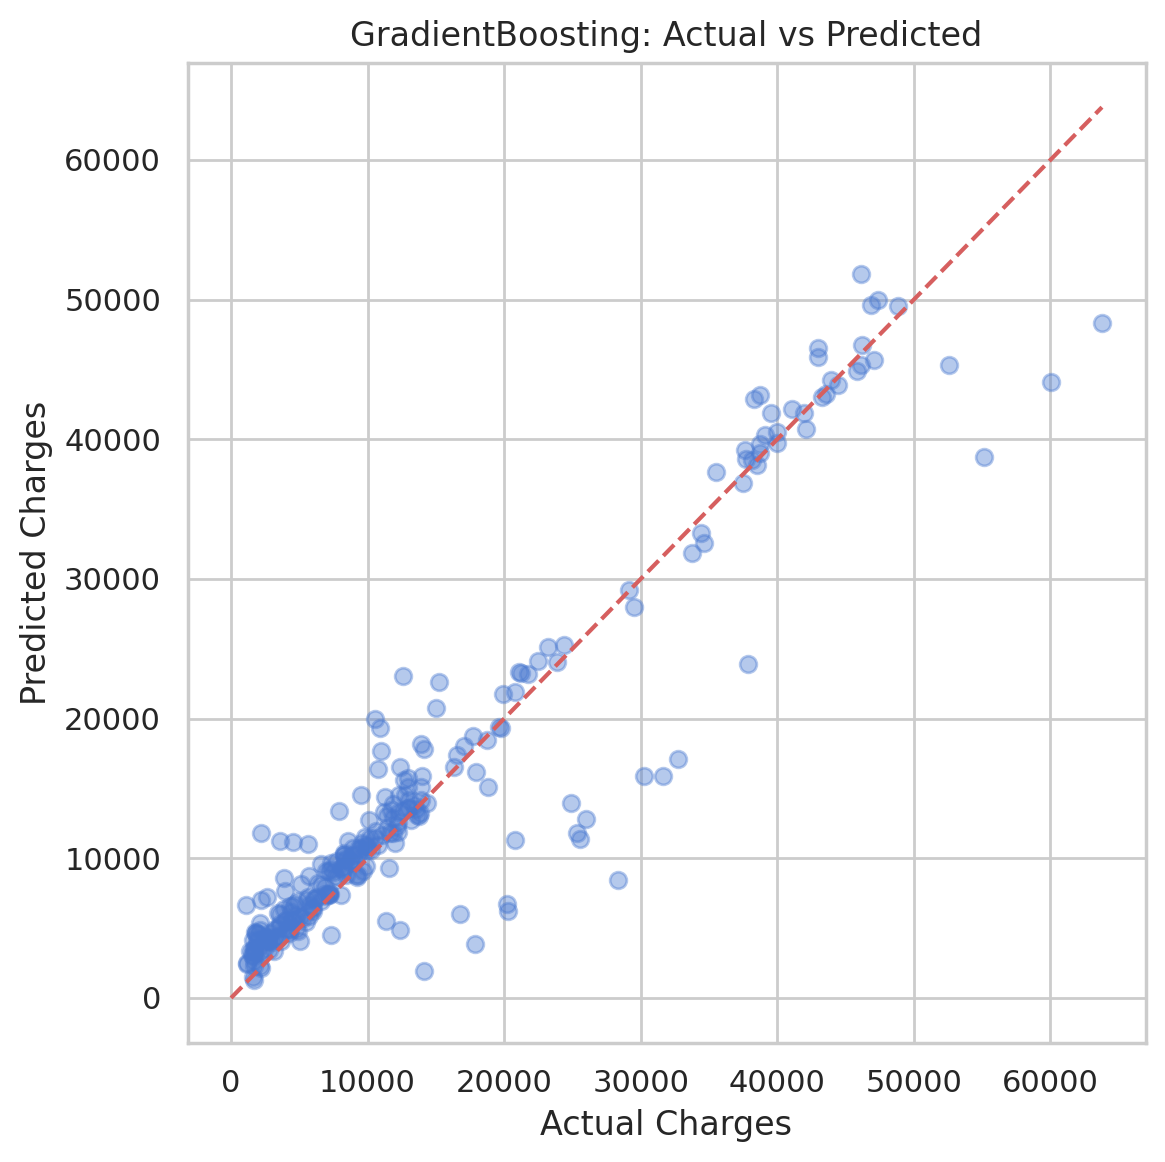

In [133]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor


drop_cols = ['charges']
target = 'charges'
categorical_features = ['sex', 'smoker', 'region', 'bmi_group', 'age_group']
X = df.drop(columns=drop_cols)
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


numeric_features = [col for col in X.columns if col not in categorical_features]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])


models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42, verbosity=0)
}


print("5‑fold CV RMSE")
cv_results_list = []
for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    scores = np.sqrt(-cross_val_score(
        pipe, X, y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1
    ))
    print(f"{name:17}: {scores.mean():.2f} ± {scores.std():.2f}")
    cv_results_list.append({'model': name, 'CV RMSE Mean': scores.mean(), 'CV RMSE Std': scores.std()})

df_cv_results = pd.DataFrame(cv_results_list).set_index('model')


results = []
best_rmse = float('inf')
best_model_name = None
best_pipe = None
best_y_pred = None

for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    results.append({
        'model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })

    if rmse < best_rmse:
        best_rmse = rmse
        best_model_name = name
        best_pipe = pipe
        best_y_pred = y_pred


df_results = pd.DataFrame(results).set_index('model')
print("\nHold‑out Metrics")
display(df_results)
print(f"\nЛучшая модель: {best_model_name} с RMSE = {best_rmse:.2f}")


plt.figure(figsize=(6,6))
plt.scatter(y_test, best_y_pred, alpha=0.4)
plt.plot([0, y_test.max()], [0, y_test.max()], 'r--')
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title(f"{best_model_name}: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

In [127]:
feat_imp_filtered = feat_imp[feat_imp > 0]
print(feat_imp_filtered)

num__bmi_age_smoker           0.682760
num__bmi                      0.144672
num__age                      0.082939
num__bmi_age                  0.057180
num__children                 0.011555
cat__smoker_no                0.010780
cat__age_group_Adult          0.002311
num__binary_smoker            0.001903
cat__region_northeast         0.001578
cat__bmi_group_overweight     0.000694
cat__region_southwest         0.000609
cat__age_group_Senior         0.000524
cat__age_group_Middle aged    0.000498
cat__region_northwest         0.000467
cat__smoker_yes               0.000406
cat__sex_female               0.000392
cat__sex_male                 0.000343
cat__bmi_group_normal         0.000175
cat__region_southeast         0.000141
cat__age_group_Young          0.000073
dtype: float64


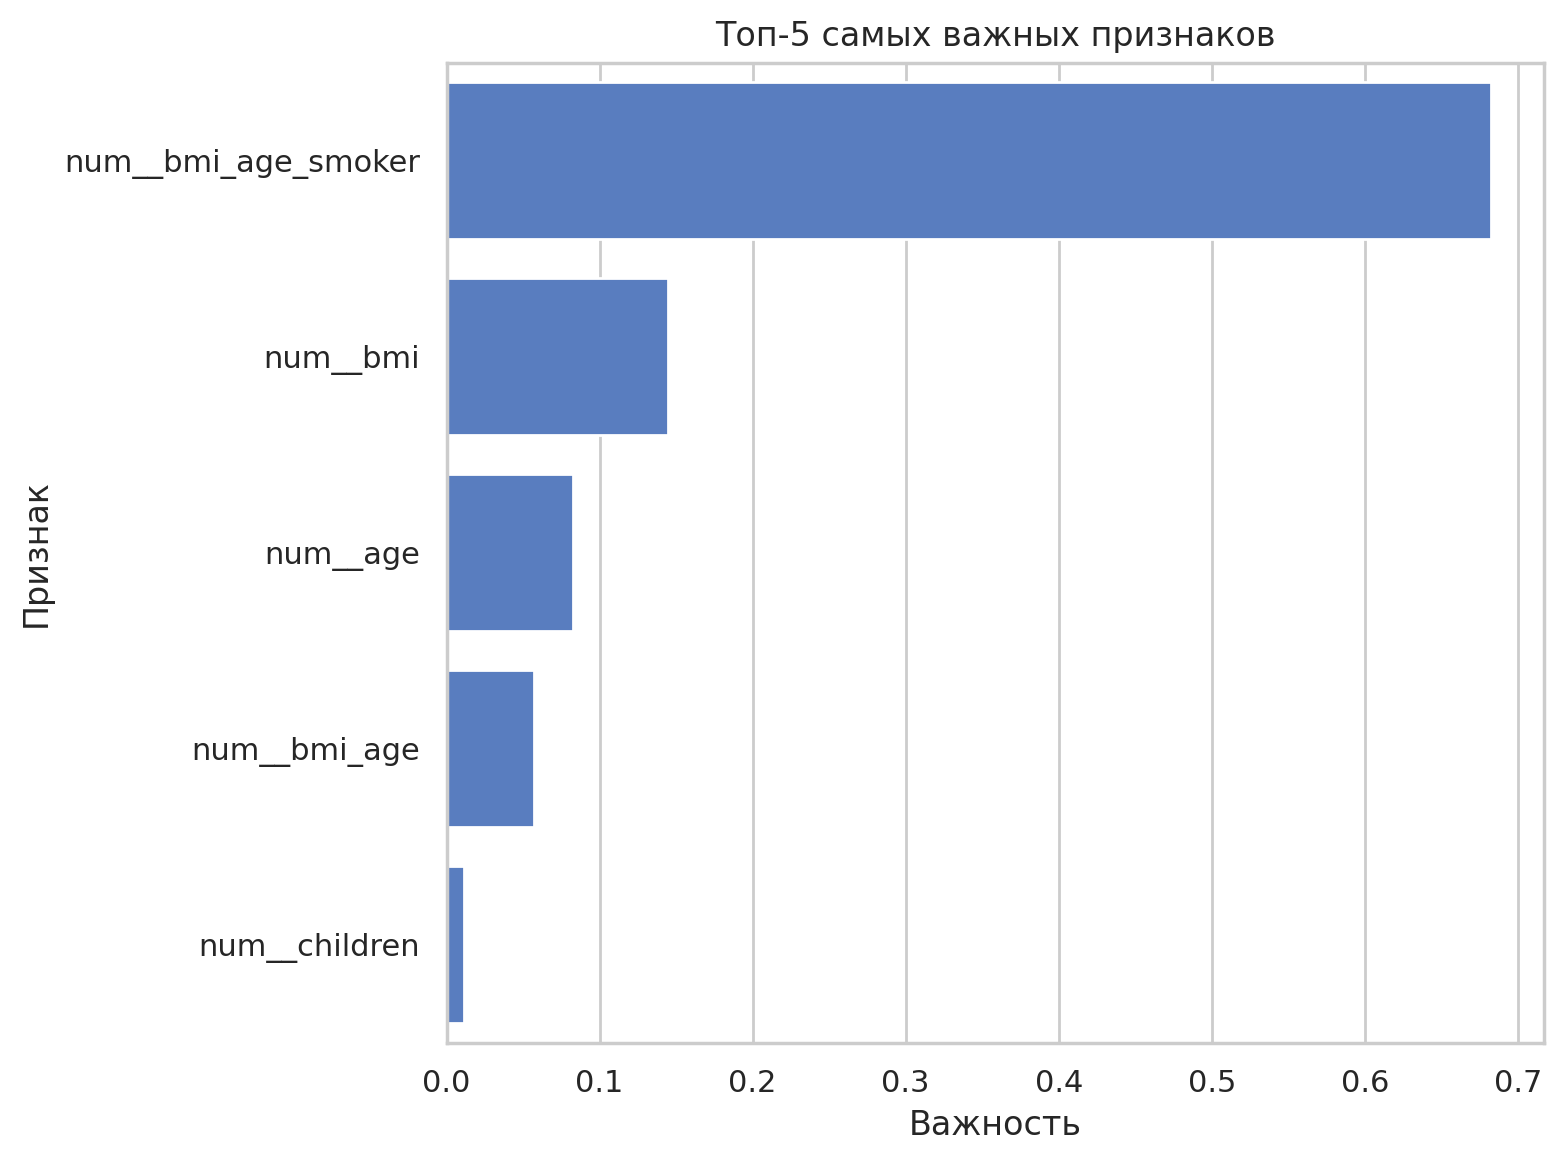

In [128]:
plt.figure(figsize=(8, 6))
sns.barplot(x=top_5_features.values, y=top_5_features.index)
plt.title('Топ-5 самых важных признаков')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

In [132]:
import joblib
joblib.dump(best_pipe, 'best_model.pkl')

['best_model.pkl']